# Create Data Cube

This notebooks aims to create a data cube of stacked sub-tile rasters, which will be ready for modelling.

## Setup

Files and system

In [1]:
import os
import json

Arrays and math

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

In [3]:
import random

Geometry

In [4]:
from shapely.geometry import Point, MultiPoint

In [5]:
from shapely.ops import transform as shapely_transform

In [6]:
from shapely import from_wkt

In [7]:
import pyproj

Raster operations

In [8]:
from scipy.ndimage import distance_transform_edt, binary_dilation

In [9]:
import rasterio
import rioxarray
from rasterio.features import rasterize

In [10]:
from rasterio.transform import from_origin

Plotting

In [11]:
import matplotlib.pyplot as plt

Logging

In [12]:
import logging
from contextlib import redirect_stdout, redirect_stderr

In [13]:
import contextlib

Directories

In [14]:
DATA_DIR = '../data/'
FIGURES_DIR = '../saved_figures/'

Habitat data

In [15]:
habitats_shp = os.path.join(DATA_DIR, 'OSPARHabitats2022_Points_clustered/OSPAR2022Points.shp')
habitats_gdf = gpd.read_file(habitats_shp)

Sub-tile grid

In [16]:
with open(os.path.join(DATA_DIR, 'tile_buffer_wkt.json'), 'r') as f:
    tiles_wkt_dict = json.load(f)

## Get sub-tiles - skip if already run

In [17]:
habitats_gdf['subtile_index'] = None

In [18]:
unknown_subtiles = dict()

In [19]:
for tileId in tiles_wkt_dict:
    habitats_sub = habitats_gdf[habitats_gdf['utm_tile'] == tileId].copy()
    subtiles = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries.from_wkt(tiles_wkt_dict[tileId]), crs="EPSG:4326"
    )
    subtiles = subtiles.reset_index().rename(columns={'index': 'subtile_index'})

    # Perform spatial join: keep only points that are inside polygons
    joined = gpd.sjoin(habitats_sub, subtiles, how='left', predicate='within')

    # Update the main DataFrame with results from spatial join
    habitats_gdf.loc[joined.index, 'subtile_index'] = joined['subtile_index_right'].astype('Int64').values

    # Find subtiles with no points
    used_subtiles = set(joined['subtile_index_right'].dropna())
    all_subtiles = set(subtiles['subtile_index'])
    unknown_subtiles[tileId] = list(all_subtiles - used_subtiles)


Save habitat data-frame and unknown subtiles.

In [20]:
habitats_gdf.to_file(habitats_shp)

/tmp/ipykernel_1359178/4024619731.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  habitats_gdf.to_file(habitats_shp)
/home/chanon/miniconda3/envs/geomlenv/lib/python3.10/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'subtile_index' to 'subtile_in'
  ogr_write(


In [21]:
with open(os.path.join(DATA_DIR, 'unknown_subtiles.json'), 'w') as f:
    json.dump(unknown_subtiles, f)

## Coastal buffer and land mask

In [17]:
def createKernel(radius):
    kernel = np.zeros((2*radius+1, 2*radius+1))
    y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    kernel[mask] = 1
    return kernel

In [18]:
def coastal_buffer(polymer_ds, idepix_ds, radius=10):
    """
    With a resolution of 20m, the default buffer distance is 10*20 = 200m.
    """
    polymer_mask = np.isnan(polymer_ds['Rw665'].values)
    idepix_land_mask = (idepix_ds['pixel_classif_flags'].astype('int32') & 2**10) != 0

    # Create buffered land mask
    buffered_land = binary_dilation(idepix_land_mask, structure=createKernel(radius))

    # Coastal buffer = buffered land minus original land
    coastal_buffer = (buffered_land & ~idepix_land_mask) & ~polymer_mask

    coastal_buffer_da = xr.DataArray(
        coastal_buffer,
        coords=idepix_ds['pixel_classif_flags'].coords,
        dims=idepix_ds['pixel_classif_flags'].dims,
        name='coastal_buffer'
    )

    return coastal_buffer_da

## Point bubbles

In [19]:
def point_bubbles(gdf, template_da, dilation_radius=2, res=20, original_crs="EPSG:4326", metric_crs="EPSG:32630"):
    reproj = pyproj.Transformer.from_crs(original_crs, metric_crs, always_xy=True).transform
    gdf_proj = gdf.to_crs(metric_crs)

    # Get transform and shape from template raster
    lat_origin = template_da['lat'].values[0, 0]
    lon_origin = template_da['lon'].values[0, 0]
    x_origin, y_origin = reproj(lon_origin, lat_origin)
    transform = from_origin(x_origin, y_origin, res, res)
    out_shape = template_da.shape
    
    shapes = [(geom, 1) for geom in gdf_proj.geometry]
    raster = rasterize(
        shapes,
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype='uint8'
    )
    raster = raster > 0

    # Use distance transform to create buffer
    distance = distance_transform_edt(~raster)
    dilated = distance <= dilation_radius

    # Wrap in a DataArray
    mask_da = xr.DataArray(
        dilated,
        coords=template_da.coords,
        dims=template_da.dims,
        name='point_bubbles_mask'
    )

    return mask_da

Example

In [20]:
tileId = '30UUA'

In [21]:
tile_habitats_gdf = habitats_gdf[(habitats_gdf['utm_tile'] == tileId) & (habitats_gdf['HabStatus'] == 'Present')]

In [22]:
tile_habitats_gdf

,GUI,RecordKey,HabType,HabSubType,HabStatus,Determiner,DetDate,SurveyKey,StartDate,EndDate,...,Longitude,AltHabType,AltHabClas,AltHabRel,SurveyDate,SurveyYear,utm_tile,Cluster,subtile_in,geometry
126932,OSPARHab2022GBDv1,MRLRC00300001263,Kelp forests,Kelp forests dominated by Laminaria hyperborea,Present,JNCC,13/07/2022,None,19/05/2017,19/05/2017,...,-5.220109,A3.1151 - [Laminaria hyperborea] forest with d...,http://dd.eionet.europa.eu/vocabulary/biodiver...,included in,2017-05-19,2017,30UUA,558,16,POINT (-5.22011 49.94791)
126933,OSPARHab2022GBDv1,MRLRC0030000126A,Kelp forests,Kelp forests dominated by Laminaria hyperborea,Present,JNCC,13/07/2022,None,18/05/2017,18/05/2017,...,-5.178603,A3.1151 - [Laminaria hyperborea] forest with d...,http://dd.eionet.europa.eu/vocabulary/biodiver...,included in,2017-05-18,2017,30UUA,558,16,POINT (-5.1786 49.96069)
126934,OSPARHab2022GBDv1,MRLRC0030000126B,Kelp forests,Kelp forests dominated by Laminaria hyperborea,Present,JNCC,13/07/2022,None,18/05/2017,18/05/2017,...,-5.180711,A3.1151 - [Laminaria hyperborea] forest with d...,http://dd.eionet.europa.eu/vocabulary/biodiver...,included in,2017-05-18,2017,30UUA,558,16,POINT (-5.18071 49.96074)
126935,OSPARHab2022GBDv1,MRLRC0030000126D,Kelp forests,Kelp forests dominated by Laminaria hyperborea,Present,JNCC,13/07/2022,None,19/05/2017,19/05/2017,...,-5.187564,A3.1151 - [Laminaria hyperborea] forest with d...,http://dd.eionet.europa.eu/vocabulary/biodiver...,included in,2017-05-19,2017,30UUA,558,16,POINT (-5.18756 49.96092)
126936,OSPARHab2022GBDv1,MRLRC00300000F7E,Kelp forests,Kelp forests dominated by Laminaria hyperborea,Present,JNCC,13/07/2022,None,29/06/2014,29/06/2014,...,-5.164993,"A3.2121 - [Laminaria hyperborea] forest, folio...",http://dd.eionet.europa.eu/vocabulary/biodiver...,included in,2014-06-29,2014,30UUA,558,17,POINT (-5.16499 50.00183)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144461,OSPARHab2022GBEv1,29737,Zostera beds,Zostera noltii beds,Present,JNCC,21/03/2023,NE_1805,None,21/03/2023,...,-4.980443,HOCI_17,https://www.marlin.ac.uk/habitats/hoci,included in,2023-03-21,2023,30UUA,1396,25,POINT (-4.98044 50.22946)
144462,OSPARHab2022GBEv1,5214,Zostera beds,Zostera noltii beds,Present,JNCC,21/03/2023,NE_1805,None,21/03/2023,...,-4.980345,HOCI_17,https://www.marlin.ac.uk/habitats/hoci,included in,2023-03-21,2023,30UUA,1396,25,POINT (-4.98034 50.22946)
144861,OSPARHab2022GBEv1,38085,Zostera beds,Zostera marina beds,Present,JNCC,21/03/2023,NE_1290,01/01/2012,31/12/2012,...,-4.635284,HOCI_17,https://www.marlin.ac.uk/habitats/hoci,included in,2012-12-31,2012,30UUA,3639,37,POINT (-4.63528 50.32452)
144891,OSPARHab2022GBEv1,13086,Zostera beds,Zostera marina beds,Present,JNCC,21/03/2023,NE_0634,01/01/2013,31/12/2013,...,-4.636634,HOCI_17,https://www.marlin.ac.uk/habitats/hoci,included in,2013-12-31,2013,30UUA,3640,37,POINT (-4.63663 50.33012)


In [66]:
idepix_fp = os.path.join(DATA_DIR, f's2_processed/{tileId}/idepix-{tileId}.nc')
idepix_ds = xr.open_dataset(idepix_fp)

In [67]:
land_mask = (idepix_ds['pixel_classif_flags'].astype('int32') & 2**10) != 0

In [68]:
template_da = idepix_ds['pixel_classif_flags']

In [69]:
bubbles_mask = point_bubbles(tile_habitats_gdf, template_da)

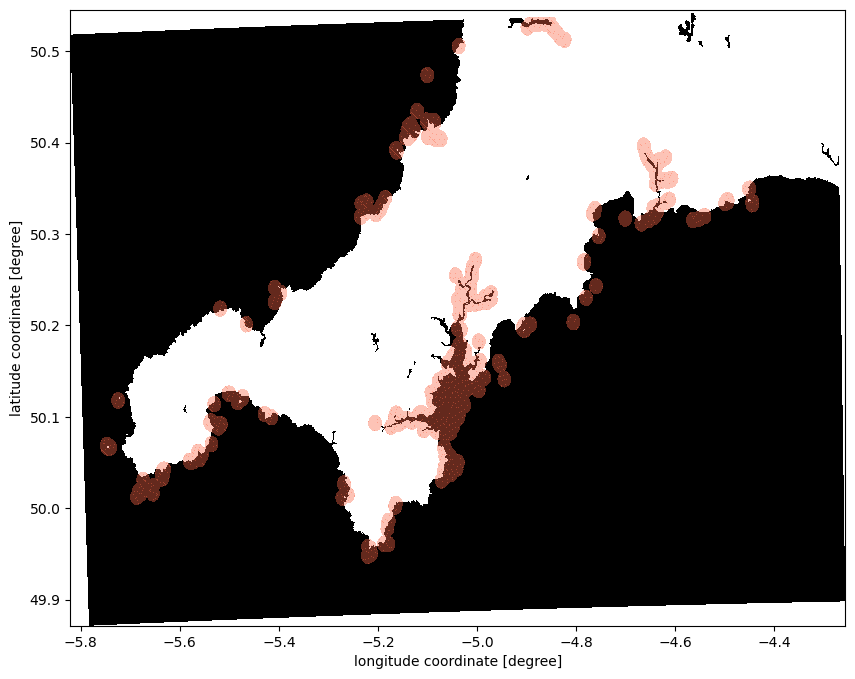

In [70]:
fig, ax = plt.subplots(figsize=(10, 8))
land_mask.plot(ax=ax, x='lon', y='lat', cmap='gray', add_colorbar=False)
bubbles_mask.where(bubbles_mask > 0).plot(
    ax=ax,
    x='lon',
    y='lat',
    cmap='Reds',
    alpha=0.4,
    add_colorbar=False
)

# tile_habitats_gdf.plot(color=tile_habitats_gdf["color"], legend=False, ax=ax, markersize=5, alpha=0.7)

# plt.savefig(os.path.join(FIGURES_DIR, 'point_bubbles_example'))

## Raster stack

In [23]:
log_file = 'raster_stack.log'
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler(log_file, mode='a')]
)
logger = logging.getLogger(__name__)

In [24]:
def rasterize_with_origin(geoms, lon_origin, lat_origin, out_shape, burn_value=1, fill=0, res=20, original_crs="EPSG:4326", metric_crs="EPSG:32630"):
    # Get transform and shape from template raster
    reproj = pyproj.Transformer.from_crs(original_crs, metric_crs, always_xy=True).transform
    x_origin, y_origin = reproj(lon_origin, lat_origin)
    transform = from_origin(x_origin, y_origin, res, res)

    # Rasterize
    raster = rasterize(
        [(shapely_transform(reproj, geom), burn_value) for geom in geoms],
        out_shape=out_shape,
        transform=transform,
        fill=fill,
        dtype='uint8'
    )

    return raster

In [25]:
with open(os.path.join(DATA_DIR, 'unknown_subtiles.json'), 'r') as f:
    unknown_subtiles = json.load(f)

Create a stack of subtiles:

N_tiles x N_subtiles x (N_bands + N_habitats) x height x width

In [26]:
habtypes = habitats_gdf['HabType'].unique()

In [27]:
habtypes_mapping = {ht: i for i, ht in enumerate(habtypes)}

In [28]:
def lprint(text):
    print(text)
    logger.info(text)

In [29]:
for tileId in tiles_wkt_dict:
    save_fp = os.path.join(DATA_DIR, f's2_processed/{tileId}/data_cube.nc')
    with contextlib.suppress(FileNotFoundError):
        os.remove(save_fp)

In [32]:
for tileId, subtiles in tiles_wkt_dict.items():
    if os.path.exists(os.path.join(DATA_DIR, f's2_processed/{tileId}/data_cube.nc')):
        lprint(f"[{tileId}] Result already exists. Skipping...")
        continue

    if tileId == '29VPD':  # skip for now, missing coastline buffer polygon
        continue

    # Sentinel-2 derivations
    try:
        lprint(f"[{tileId}] Loading Sentinel-2 derivations...")
        idepix_df = os.path.join(DATA_DIR, f's2_processed/{tileId}/idepix-{tileId}.nc')
        idepix_ds = xr.open_dataset(idepix_df)
        polymer_fp = os.path.join(DATA_DIR, f's2_processed/{tileId}/polymer-{tileId}.nc')
        polymer_ds = xr.open_dataset(polymer_fp).drop_attrs()
        polymer_ds = polymer_ds.set_coords(("latitude", "longitude"))
        polymer_ds = polymer_ds.rename(latitude='lat', longitude='lon', height='y', width='x')
    except Exception as e:
        lprint(f"[{tileId}] Error loading required files, so skipping. Error: {e}")
        continue

    # Masks
    lprint(f"[{tileId}] Creating masks...")
    example_da = polymer_ds['Rw665']
    polymer_mask = np.isnan(example_da.values)
    land_mask = (idepix_ds['pixel_classif_flags'].astype('int32') & 2**10) != 0
    land_mask = land_mask | polymer_mask

    # Coastal buffer
    coastal_buffer_da = coastal_buffer(polymer_ds, idepix_ds).astype(bool)

    # Add coastal buffer as a variable
    polymer_ds = polymer_ds.assign(coastal_buffer=coastal_buffer_da)

    # Habitats dataframe
    tile_habitats_gdf = habitats_gdf[(habitats_gdf['utm_tile'] == tileId) & (habitats_gdf['HabStatus'] == 'Present')]
    tile_habtypes = tile_habitats_gdf['HabType'].unique()
    
    for habtype in habtypes:
        habtype_id = habtypes_mapping[habtype]
        lprint(f"[{tileId}] Creating point bubble layer for habtype {habtype}.")
        
        if habtype in tile_habtypes:
            target_gdf = tile_habitats_gdf[tile_habitats_gdf['HabType'] == habtype]
            bubbles_mask = point_bubbles(target_gdf, example_da)
            bubbles_mask.name = f'habitat_{habtype_id}'
        else:
            # Empty DataArray
            zeros_arr = np.zeros(example_da.shape, dtype='uint8')
            bubbles_mask = xr.DataArray(
                zeros_arr,
                coords=example_da.coords,
                dims=example_da.dims,
                name=f'habitat_{habtype_id}'
            )

        # Assign to polymer_ds
        assign_dict = {f'habitat_{habtype_id}': bubbles_mask}
        polymer_ds = polymer_ds.assign(**assign_dict)

    # To store clipped datasets
    datasets = []

    max_x = 0
    max_y = 0
    
    # Clip datasets by subtiles
    lprint(f"[{tileId}] Clipping by subtiles: {len(subtiles)}")
    for subtile_in, subtile_wkt in enumerate(subtiles):
        # Create shallow copy of polymer_ds
        subtile_polymer = polymer_ds.copy()
        
        # Create subtile mask
        latitudes = example_da['lat'].values.ravel()
        longitudes = example_da['lon'].values.ravel()
        subtile_geom = from_wkt(subtile_wkt)
        subtile_mask = rasterize_with_origin(
            [subtile_geom],
            longitudes[0],
            latitudes[0],
            example_da.shape
        )

        if not subtile_mask.any():
            lprint(f"[{tileId}] Null intersection with subtile {subtile_in}")
            continue
        
        subtile_mask_da = xr.DataArray(
            subtile_mask,
            coords=example_da.coords,
            dims=example_da.dims,
        ).astype(bool)
        
        # Clip by subtile_mask values
        clipped_ds = subtile_polymer.where(subtile_mask_da, drop=True)

        # Add subtile_in as a dimension
        clipped_ds = clipped_ds.expand_dims(subtile_in=[subtile_in])

        # Add "unknown_flag" as a scalar variable with tileId as dim
        unknown_flag = subtile_in in unknown_subtiles[tileId]
        clipped_ds["unknown_flag"] = xr.DataArray([unknown_flag], dims=["subtile_in"])
        
        # Store result
        datasets.append(clipped_ds)

        # Get maximum width and height
        max_x = max(max_x, clipped_ds.sizes['x'])
        max_y = max(max_y, clipped_ds.sizes['y'])

    # Pad x and y dimensions
    for i, ds in enumerate(datasets):
        pad_width = {
            'x': (0, max_x - ds.sizes['x']),
            'y': (0, max_y - ds.sizes['y'])
        }
        datasets[i] = ds.pad(**pad_width, constant_value=np.nan)
    
    # Concatenate along subtile_in
    lprint(f"[{tileId}] Combining datasets")
    combined = xr.concat(datasets, dim='subtile_in')
    combined = combined.expand_dims(tileId=[tileId])
    lprint(f"[{tileId}] Saving data cube")

    save_fp = os.path.join(DATA_DIR, f's2_processed/{tileId}/data_cube.nc')
    combined.to_netcdf(save_fp)

[29UPR] Loading Sentinel-2 derivations...
[29UPR] Creating masks...
[29UPR] Creating point bubble layer for habtype Zostera beds.
[29UPR] Creating point bubble layer for habtype Lophelia pertusa reefs.
[29UPR] Creating point bubble layer for habtype Carbonate mounds.
[29UPR] Creating point bubble layer for habtype Coral gardens.
[29UPR] Creating point bubble layer for habtype Sea-pen and burrowing megafauna communities.
[29UPR] Creating point bubble layer for habtype Deep-sea sponge aggregations.
[29UPR] Creating point bubble layer for habtype Kelp forests.
[29UPR] Creating point bubble layer for habtype Maerl beds.
[29UPR] Creating point bubble layer for habtype Intertidal Mytilus edulis beds on mixed and sandy sediments.
[29UPR] Creating point bubble layer for habtype Ostrea edulis beds.
[29UPR] Creating point bubble layer for habtype Modiolus modiolus horse mussel beds.
[29UPR] Creating point bubble layer for habtype Intertidal mudflats.
[29UPR] Creating point bubble layer for habty